# **Cross-Region Sensitivity Analysis with Sobol and SHAP using XGBoost**

The objective of performing cross-region sensitivity analysis with Sobol and SHAP metrics using surrogate models is to identify and compare the factors that most influence model outputs under different operating conditions or parameter ranges (“regions”).

By leveraging surrogate models, we can efficiently approximate complex system behavior, allowing for repeated sensitivity evaluations at low computational cost. Sobol indices provide a global variance-based measure of importance, capturing both main effects and interactions, while SHAP values offer a consistent, model-agnostic interpretation of each feature’s contribution to predictions.

Comparing these metrics across regions enables us to detect whether key drivers remain stable or vary depending on the operating context. This information supports more targeted optimization, improved interpretability of the model, and robust decision-making across the full range of possible scenarios.

In [ ]:
import gc
gc.collect()
import numpy as np
import pandas as pd
import os
import sys
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import shap
from datetime import datetime

# Adjust the path to point to external/AlphaPEM
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.utils.FE_formatting import load_parameter_ranges
from src.analysis.feature_effects import FeatureEffects
from src.validity.validity_criteria import validate_polarization_curves
from src.utils.FE_io import load_cv_results, save_FE_results, load_FE_results
from FE.FE_plotting import plot_shap_bar, plot_sobol_index_convergence, plot_sobol_ranking, plot_top_k_rankings_across_regions
from src.utils.auxiliar_func_FE import select_top_features,build_feature_ranking_table

d:\Users\kju10\Documents\LMU-STATISTICS & DATA SCIENCE MASTER\WS2425\Consulting\project\Official-Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Load the model**
This section loads and applies pre-trained surrogate models to generate the outputs required for the sensitivity analysis.

In [2]:
model_xgboost, best_params_xgboost, metrics_xgboost = load_cv_results(
    save_dir='../results/surrogate_models/xgboost',
    run_name='xgb_nconfig_50000_no_neg_with_outerCV'
)

[INFO] Loaded model from ../results/surrogate_models/xgboost\xgb_nconfig_50000_no_neg_with_outerCV_final_model.pkl
[INFO] Loaded hyperparameters from ../results/surrogate_models/xgboost\xgb_nconfig_50000_no_neg_with_outerCV_best_params.json
[INFO] Loaded metrics from ../results/surrogate_models/xgboost\xgb_nconfig_50000_no_neg_with_outerCV_metrics.json


We define the max N used in the sobol analysis to evaluate convergence

In [11]:
max_N_sobol_convergence = 8192

We load the timestamp configuration and the path to save the results.

In [ ]:
core_training = OmegaConf.load('../configs/core_training_cfg.yaml')
timestamp_format = core_training['save']['timestamp_format']
path_results="../results/surrogate_models/feature_effects/xgboost"


## **Load valid data**

In [ ]:
sys.path.append(os.path.abspath("../external/AlphaPEM"))
data = pd.read_pickle(r"../data/processed/validated_final_57344.pkl")
data = data[data['classification'] == 'valid']
param_config,parameter_ranges, parameter_names= load_parameter_ranges('../configs/param_config.yaml')

The validation criteria for polarization curves are loaded from an external YAML configuration file. These criteria include the acceptable voltage range, thresholds for approximate monotonicity, and other rules defined under the `criteria` section. The `validate_polarization_curves` function applies these rules to the dataset, filtering out curves that do not meet the specified requirements. The resulting validated_df contains only curves considered valid for further analysis, with the total number of retained observations displayed for verification.

In [4]:
valid_criteria = OmegaConf.load('../configs/valid_polarization_curve_cfg.yaml')
validated_df = validate_polarization_curves(
    data,
    apply_criteria=valid_criteria['criteria'],
    filter_invalid=True,
    voltage_range=valid_criteria['voltage_range'],
    approx_monotonic_threshold=valid_criteria['approx_monotonic_threshold']
)

print(len(validated_df))  # Should be 54754

54754


The dataset is reshaped from a wide format, where voltage (`Ucell`) and current density (`ifc`) values are stored as lists within each configuration, to a long format in which each row represents a unique combination of configuration parameters and a single pair of voltage–current values. This transformation ensures one observation per configuration–voltage pair, facilitating subsequent analysis and visualization.

In [5]:
columns = list(parameter_ranges.keys())
columns.extend(['Ucell', 'ifc', 'SHA256'])

df_exploded = data[columns].explode(['ifc', 'Ucell'], ignore_index=True)
df_exploded.shape

(1745672, 16)

Rows with negative voltage (Ucell) values are removed to ensure that only physically meaningful and valid operating conditions are included in the analysis. This filtering step helps maintain the quality and interpretability of the results.

In [6]:
df_exploded = df_exploded[df_exploded.Ucell>=0]
df_exploded.shape

(1708686, 16)

For each defined operational region, we perform both Sobol sensitivity analysis and SHAP value computation to quantify feature importance from complementary perspectives. The Sobol method captures the contribution of each feature to output variance, including interaction effects, while SHAP values estimate the marginal impact of each feature on model predictions. After completing the analyses for all regions, the resulting metrics are stored in the previously defined output path for subsequent processing, comparison, and visualization.

## **Activation**

In [9]:
# Optionally, load the results
#FE_act_shap_results, FE_act_sobol_ = load_FE_results(region_name = "activation", 
                #save_dir = "../results/sm/xgboost", 
                #tag="17072025")

In [7]:
FE_act = FeatureEffects(model=model_xgboost, parameter_ranges =parameter_ranges, region="activation")

In [11]:
RAW_shap_values_act, FE_act_shap_results = FE_act.shap(df= df_exploded, target_col='Ucell', sample_frac=1.0, verbose=True)

[WARN] Found non-numeric columns: ['ifc']
[INFO] Converted column 'ifc' to numeric.
[INFO] Using full dataset (225101 rows) for SHAP.
[INFO] Creating SHAP TreeExplainer...
[INFO] Computing SHAP values...
[INFO] columns ['Tfc', 'Pa_des', 'Sc', 'Phi_c_des', 'epsilon_gdl', 'tau', 'epsilon_mc', 'epsilon_c', 'e', 'Re', 'i0_c_ref', 'kappa_co', 'kappa_c', 'ifc']
[INFO] Aggregating mean absolute SHAP values per feature...


In [12]:
FE_act_shap_results

,feature,mean_abs_shap
13,ifc,0.240813
10,i0_c_ref,0.043041
12,kappa_c,0.029081
0,Tfc,0.025537
1,Pa_des,0.022604
9,Re,0.010377
5,tau,0.009832
11,kappa_co,0.008020
6,epsilon_mc,0.007924
2,Sc,0.006282


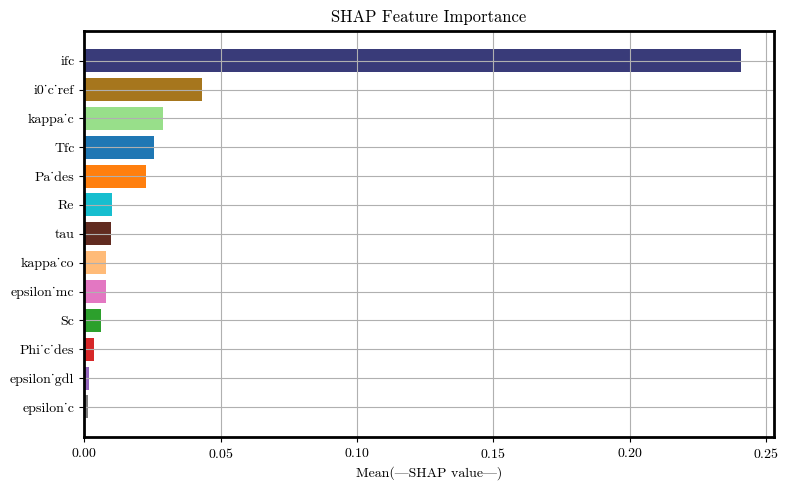

In [13]:
plot_shap_bar(FE_act_shap_results)

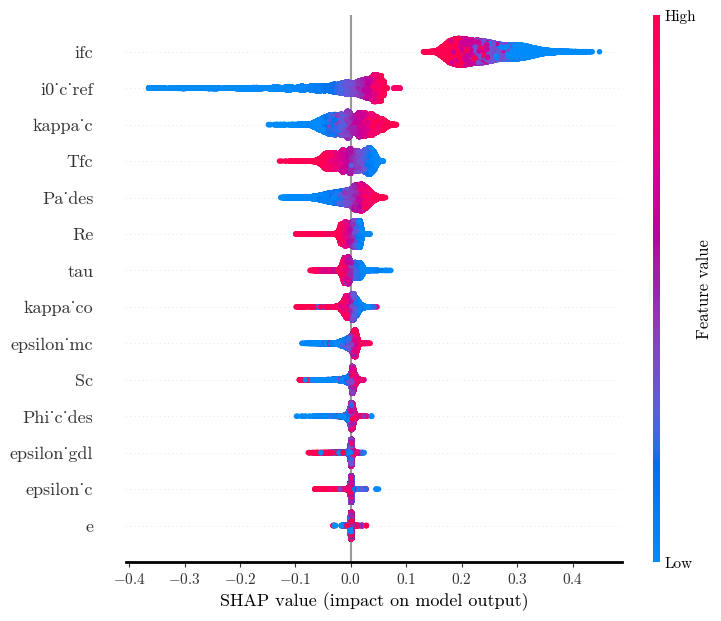

In [15]:
shap.plots.beeswarm(RAW_shap_values_act, max_display=14)

In [ ]:
N_list = [2**i for i in range(int(np.log2(2)), int(np.log2(max_N_sobol_convergence)) + 1)] 
FE_act_sobol_ = FE_act.sobol(N_list= N_list, calculate_second_order=True,verbose=False)

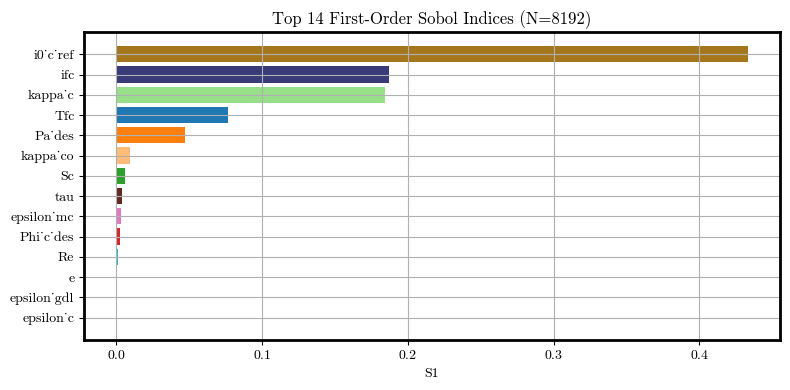

In [ ]:
plot_sobol_ranking({max_N_sobol_convergence: FE_act_sobol_[max_N_sobol_convergence]}, top_n=14)

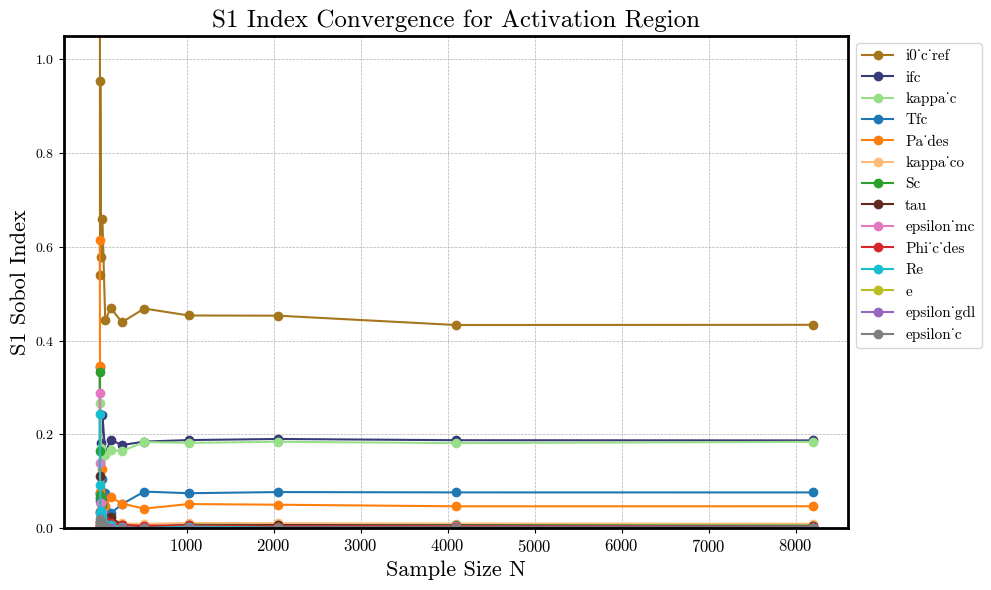

In [ ]:
plot_sobol_index_convergence(FE_act_sobol_, top_k=14, index_type="S1", log_x=False, region = "Activation",max_N=max_N_sobol_convergence,step=1000)

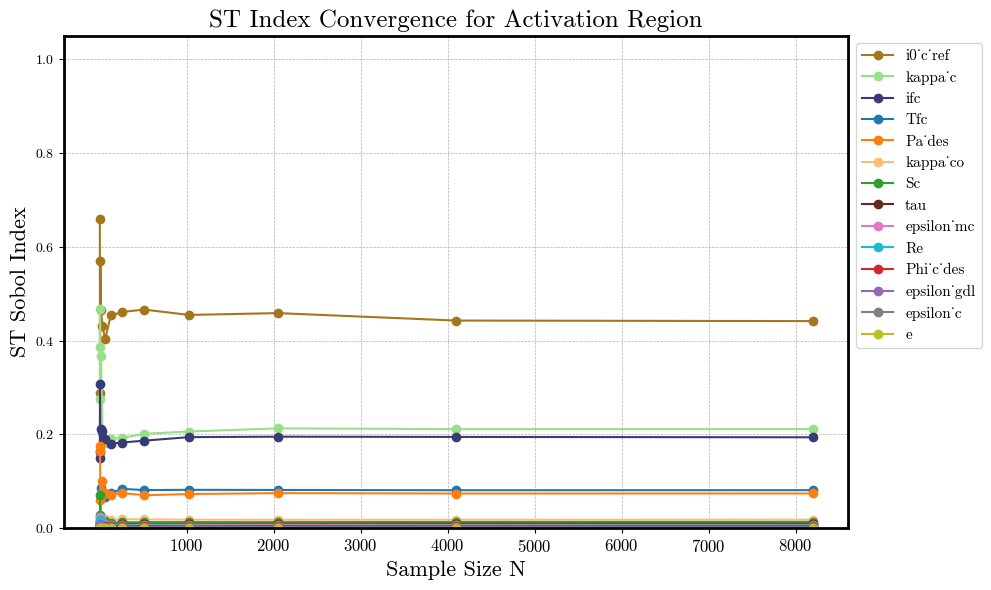

In [ ]:
plot_sobol_index_convergence(FE_act_sobol_, top_k=14, index_type="ST", log_x=False, region = "Activation",max_N=max_N_sobol_convergence,step=1000)

In [ ]:
save_FE_results(
    region_name="activation",
    raw_shap =RAW_shap_values_act,
    shap_df =FE_act_shap_results,
    sobol_results=FE_act_sobol_,
    save_dir=path_results,
    tag= datetime.now().strftime(timestamp_format)
)

[INFO] Saved SHAP ranking to ../results/sm/xgboost\xgb_activation_28072025_shap.csv
[INFO] Saved raw SHAP Explanation to ../results/sm/xgboost\xgb_activation_28072025_raw_shap.pkl
[INFO] Saved all Sobol results to ../results/sm/xgboost\xgb_activation_28072025_sobol_results.pkl


## **Ohmic**

In [ ]:
# Optionally, load the results
#FE_ohm_shap_results, FE_ohm_sobol_ = load_FE_results(region_name = "ohmic", 
#                save_dir = "../results/sm/xgboost", 
#                tag="17072025")

[INFO] Loaded SHAP ranking from ../results/sm/xgboost\xgb_ohmic_17072025_shap.csv
[WARN] Sobol results not found: ../results/sm/xgboost\xgb_ohmic_17072025_sobol_results.pkl


In [40]:
FE_ohm = FeatureEffects(model=model_xgboost, parameter_ranges =parameter_ranges, region="ohmic")

In [11]:
RAW_shap_values_ohm, FE_ohm_shap_results = FE_ohm.shap(df= df_exploded, target_col='Ucell', sample_frac=1.0, verbose=True)

[WARN] Found non-numeric columns: ['ifc']
[INFO] Converted column 'ifc' to numeric.
[INFO] Using full dataset (666062 rows) for SHAP.
[INFO] Creating SHAP TreeExplainer...
[INFO] Computing SHAP values...
[INFO] columns ['Tfc', 'Pa_des', 'Sc', 'Phi_c_des', 'epsilon_gdl', 'tau', 'epsilon_mc', 'epsilon_c', 'e', 'Re', 'i0_c_ref', 'kappa_co', 'kappa_c', 'ifc']
[INFO] Aggregating mean absolute SHAP values per feature...


In [12]:
FE_ohm_shap_results

,feature,mean_abs_shap
13,ifc,0.067320
10,i0_c_ref,0.042765
1,Pa_des,0.030510
0,Tfc,0.029974
12,kappa_c,0.026851
9,Re,0.014544
5,tau,0.013732
6,epsilon_mc,0.010955
3,Phi_c_des,0.006994
2,Sc,0.005556


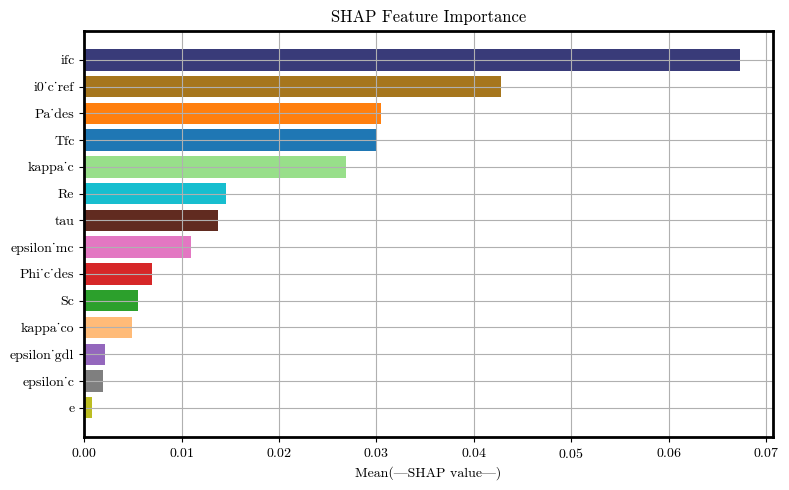

In [13]:
plot_shap_bar(FE_ohm_shap_results, top_n=14)

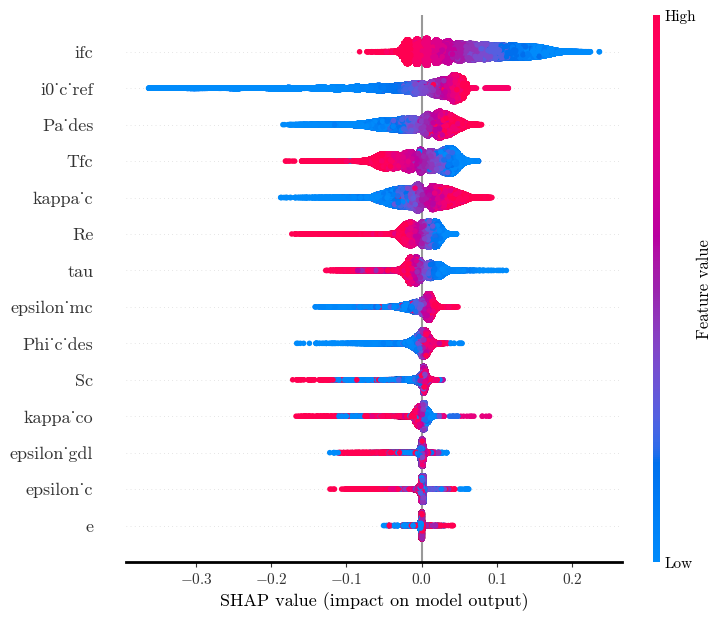

In [14]:
shap.plots.beeswarm(RAW_shap_values_ohm, max_display=14)

In [ ]:
N_list = [2**i for i in range(int(np.log2(2)), int(np.log2(max_N_sobol_convergence)) + 1)] 
FE_ohm_sobol_ = FE_ohm.sobol(N_list= N_list, calculate_second_order=True,verbose=False)

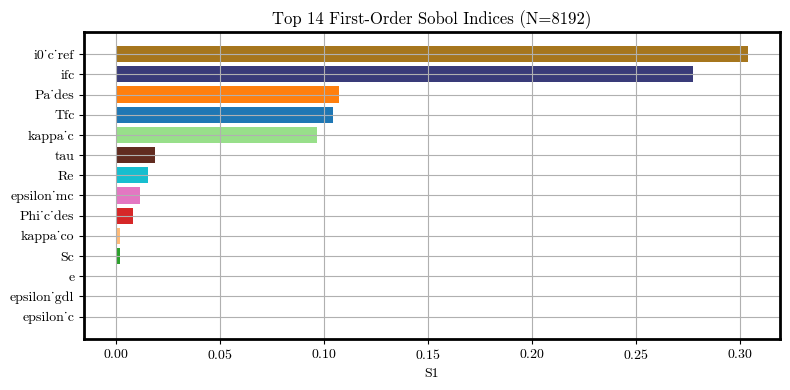

In [ ]:
plot_sobol_ranking({max_N_sobol_convergence: FE_ohm_sobol_[max_N_sobol_convergence]}, top_n=14)

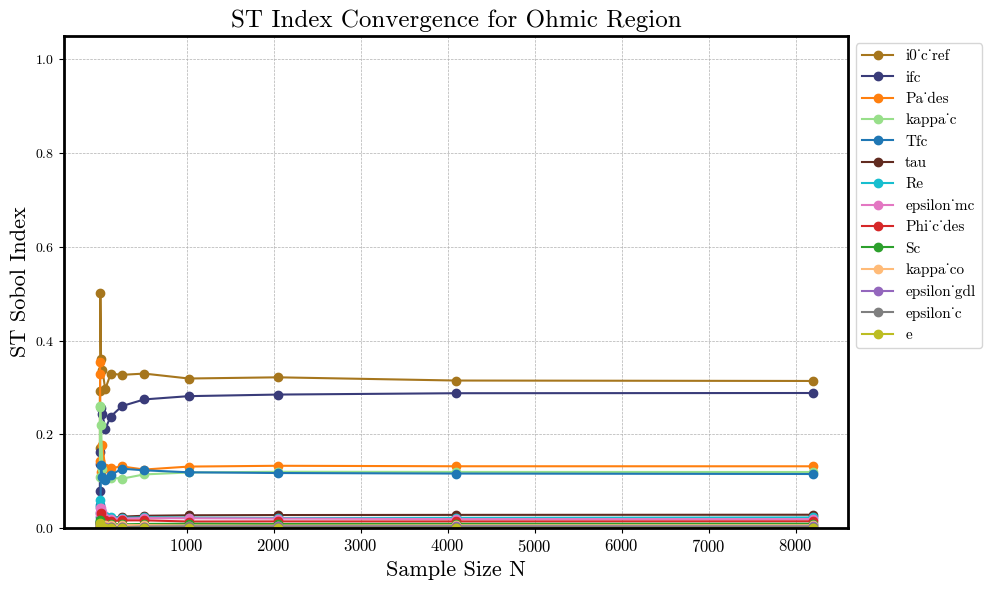

In [ ]:
plot_sobol_index_convergence(FE_ohm_sobol_, top_k=14, index_type="ST", log_x=False, region = "Ohmic",max_N=max_N_sobol_convergence,step=1000)

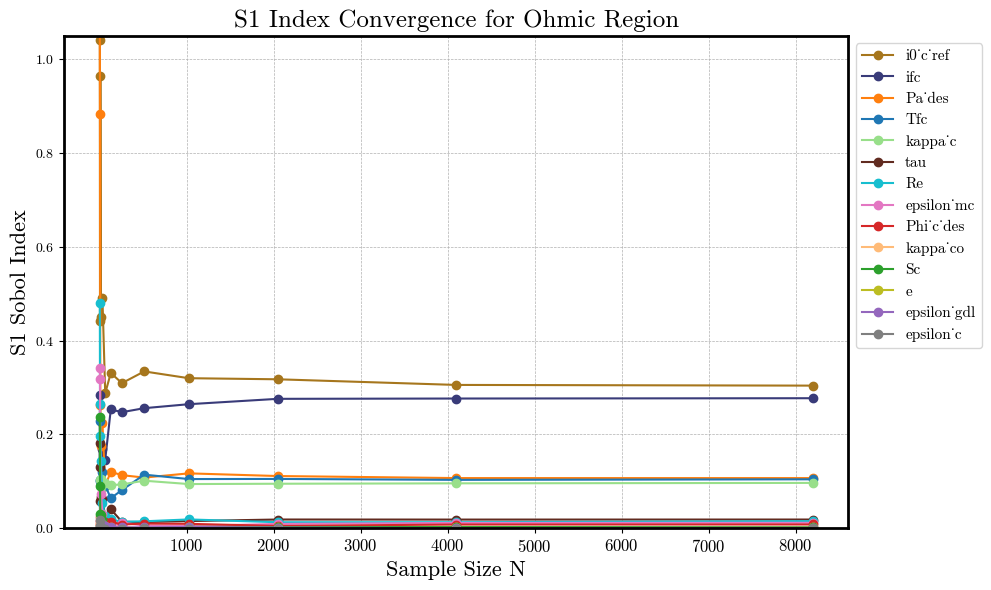

In [ ]:
plot_sobol_index_convergence(FE_ohm_sobol_, top_k=14, index_type="S1", log_x=False, region = "Ohmic",max_N=max_N_sobol_convergence,step=1000)

In [ ]:
save_FE_results(
    region_name="ohmic",
    raw_shap =RAW_shap_values_ohm,
    shap_df =FE_ohm_shap_results,
    sobol_results=FE_ohm_sobol_,
    save_dir=path_results,
    tag=datetime.now().strftime(timestamp_format)
)

[INFO] Saved SHAP ranking to ../results/sm/xgboost\xgb_ohmic_28072025_shap.csv
[INFO] Saved raw SHAP Explanation to ../results/sm/xgboost\xgb_ohmic_28072025_raw_shap.pkl
[INFO] Saved all Sobol results to ../results/sm/xgboost\xgb_ohmic_28072025_sobol_results.pkl


## **Mass transport**

In [ ]:
# Optionally, load the results
#FE_mass_shap_results, FE_mass_sobol_ = load_FE_results(region_name = "mass_transport", 
#                save_dir = "../results/sm/xgboost", 
#                tag="17072025")

[INFO] Loaded SHAP ranking from ../results/sm/xgboost\xgb_mass_transport_17072025_shap.csv
[INFO] Loaded Sobol results from ../results/sm/xgboost\xgb_mass_transport_17072025_sobol_results.pkl


In [45]:
FE_mass = FeatureEffects(model=model_xgboost, parameter_ranges =parameter_ranges, region="mass_transport")

In [22]:
RAW_shap_values_mass, FE_mass_shap_results = FE_mass.shap(df= df_exploded, target_col='Ucell', sample_frac=1.0, verbose=True)

[WARN] Found non-numeric columns: ['ifc']
[INFO] Converted column 'ifc' to numeric.
[INFO] Using full dataset (817523 rows) for SHAP.
[INFO] Creating SHAP TreeExplainer...
[INFO] Computing SHAP values...
[INFO] columns ['Tfc', 'Pa_des', 'Sc', 'Phi_c_des', 'epsilon_gdl', 'tau', 'epsilon_mc', 'epsilon_c', 'e', 'Re', 'i0_c_ref', 'kappa_co', 'kappa_c', 'ifc']
[INFO] Aggregating mean absolute SHAP values per feature...


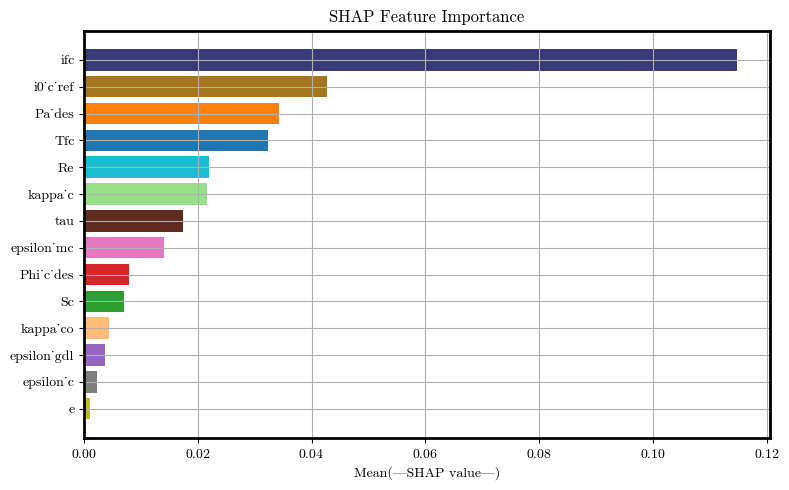

In [ ]:
plot_shap_bar(FE_mass_shap_results,top_n=14)

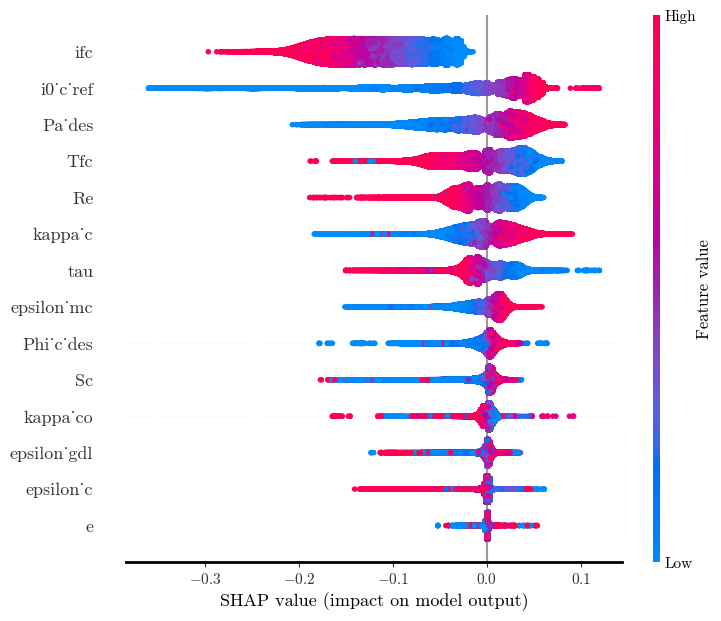

In [25]:
shap.plots.beeswarm(RAW_shap_values_mass, max_display=14)

In [ ]:
N_list = [2**i for i in range(int(np.log2(2)), int(np.log2(max_N_sobol_convergence)) + 1)] 
FE_mass_sobol_ = FE_mass.sobol(N_list= N_list, calculate_second_order=True,verbose=False)

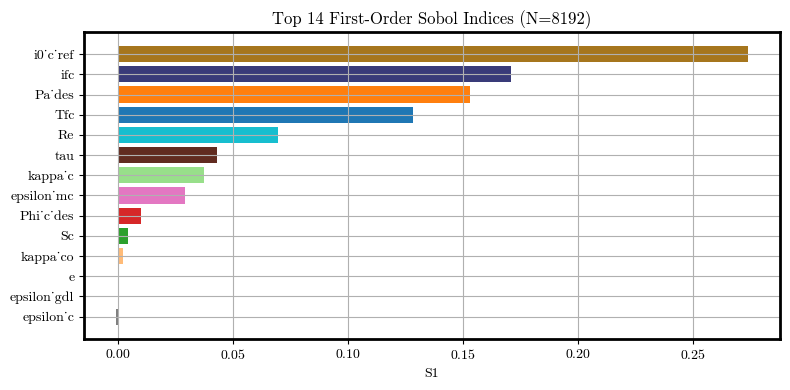

In [48]:
max_key = max(FE_mass_sobol_.keys())
plot_sobol_ranking({max_key: FE_mass_sobol_[max_key]}, top_n=14)

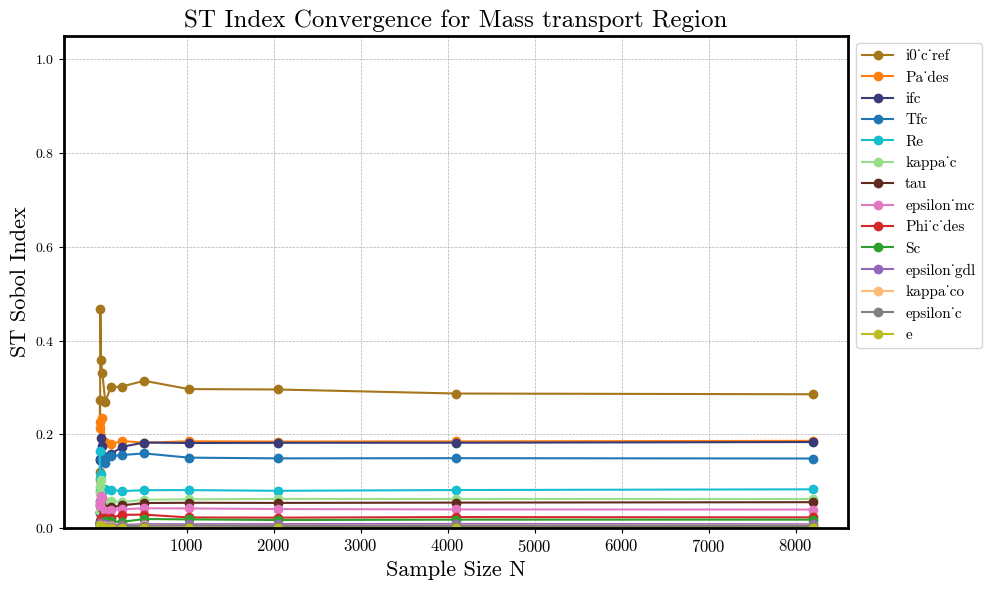

In [ ]:
plot_sobol_index_convergence(FE_mass_sobol_, top_k=14, index_type="ST", log_x=False, region = "Mass Transport",max_N=max_N_sobol_convergence,step=1000)

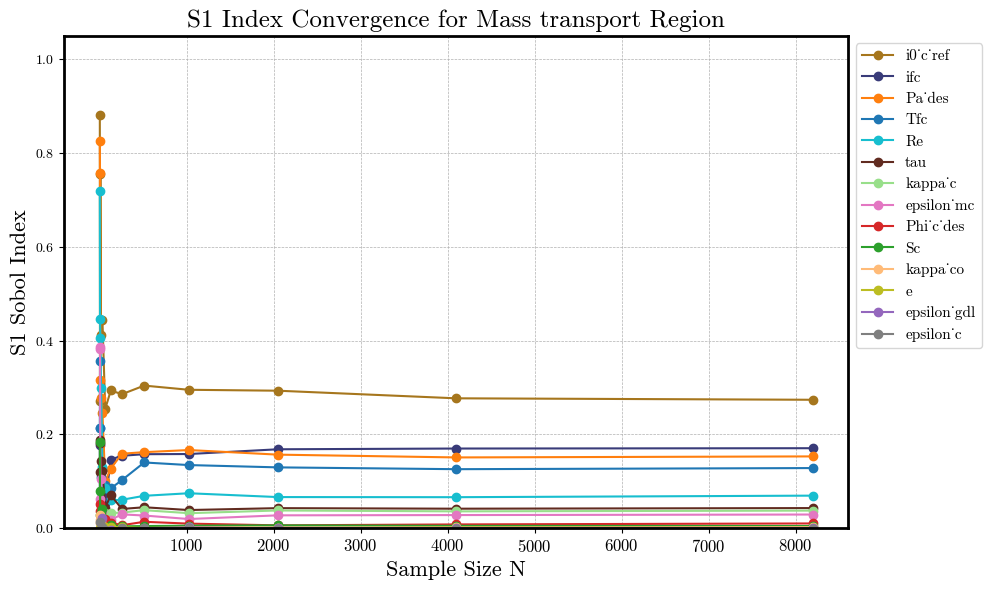

In [ ]:
plot_sobol_index_convergence(FE_mass_sobol_, top_k=14, index_type="S1", log_x=False, region = "Mass Transport",max_N=max_N_sobol_convergence,step=1000)

In [ ]:
save_FE_results(
    region_name="mass_transport",
    raw_shap =RAW_shap_values_mass,
    shap_df =FE_mass_shap_results,
    sobol_results=FE_mass_sobol_,
    save_dir=path_results,
    tag=datetime.now().strftime(timestamp_format)
)

[INFO] Saved SHAP ranking to ../results/sm/xgboost\xgb_mass_transport_28072025_shap.csv
[INFO] Saved raw SHAP Explanation to ../results/sm/xgboost\xgb_mass_transport_28072025_raw_shap.pkl
[INFO] Saved all Sobol results to ../results/sm/xgboost\xgb_mass_transport_28072025_sobol_results.pkl


After completing the analyses, the saved results are reloaded and used to generate the visualizations included in the final presentation. These plots summarize the key findings, highlighting feature importance patterns and comparisons across regions, and serve as a concise visual synthesis of the analysis outcomes.

## Read the files to get the summary

In [4]:
FE_act_shap_results, RAW_shap_values_act ,FE_act_sobol_ = load_FE_results(
    region_name="activation",
    save_dir=path_results,
    tag="28072025"
)


FE_ohm_shap_results, RAW_shap_values_ohm,FE_ohm_sobol_ = load_FE_results(
    region_name="ohmic",
    save_dir=path_results,
    tag="28072025"
)


FE_mass_shap_results, RAW_shap_values_mass,FE_mass_sobol_ = load_FE_results(
    region_name="mass_transport",
    save_dir=path_results,
    tag="28072025"
)

[INFO] Loaded SHAP ranking from ../results/surrogate_models/feature_effects/xgboost\xgb_activation_28072025_shap.csv
[INFO] Loaded raw SHAP Explanation from ../results/surrogate_models/feature_effects/xgboost\xgb_activation_28072025_raw_shap.pkl
[INFO] Loaded Sobol results from ../results/surrogate_models/feature_effects/xgboost\xgb_activation_28072025_sobol_results.pkl
[INFO] Loaded SHAP ranking from ../results/surrogate_models/feature_effects/xgboost\xgb_ohmic_28072025_shap.csv
[INFO] Loaded raw SHAP Explanation from ../results/surrogate_models/feature_effects/xgboost\xgb_ohmic_28072025_raw_shap.pkl
[INFO] Loaded Sobol results from ../results/surrogate_models/feature_effects/xgboost\xgb_ohmic_28072025_sobol_results.pkl
[INFO] Loaded SHAP ranking from ../results/surrogate_models/feature_effects/xgboost\xgb_mass_transport_28072025_shap.csv
[INFO] Loaded raw SHAP Explanation from ../results/surrogate_models/feature_effects/xgboost\xgb_mass_transport_28072025_raw_shap.pkl
[INFO] Loaded S

## Plots and tables for the final presentation
In this section, we present the plots and summaries used in the final presentation.

1. **Detailed Sobol First and Second -Order Indices:**
We begin by showing the detailed values of the first and second-order Sobol indices for each feature.

In [5]:
FE_mass_sobol_[max_N_sobol_convergence]['sobol_df']

,feature,S1,S1_CI,ST,ST_CI,S2_total,S2_CI
0,i0_c_ref,0.273354,"(0.255, 0.291)",0.285164,"(0.272, 0.299)",0.004424,"(-0.08, 0.089)"
1,ifc,0.172609,"(0.161, 0.185)",0.186311,"(0.179, 0.194)",0.000000,"(0.0, 0.0)"
2,Pa_des,0.152373,"(0.14, 0.165)",0.185339,"(0.178, 0.193)",0.038121,"(-0.203, 0.28)"
3,Tfc,0.128192,"(0.118, 0.139)",0.148554,"(0.142, 0.155)",-0.014818,"(-0.232, 0.203)"
4,Re,0.069569,"(0.06, 0.079)",0.083003,"(0.08, 0.086)",0.004475,"(-0.05, 0.059)"
5,kappa_c,0.036081,"(0.028, 0.044)",0.060771,"(0.058, 0.063)",0.002259,"(-0.009, 0.013)"
6,tau,0.042606,"(0.036, 0.049)",0.055016,"(0.052, 0.058)",0.006850,"(-0.066, 0.08)"
7,epsilon_mc,0.029046,"(0.022, 0.036)",0.039519,"(0.038, 0.041)",-0.011413,"(-0.076, 0.053)"
8,Phi_c_des,0.010420,"(0.006, 0.015)",0.023469,"(0.021, 0.025)",-0.008079,"(-0.076, 0.06)"
9,Sc,0.004694,"(0.001, 0.009)",0.018997,"(0.018, 0.02)",0.017602,"(-0.046, 0.082)"


2. **Ranking across regions comparison:**
These plots show how the relative importance (ranking) of parameters changes across different regions of current density using Sobol and SHAP values.
Each line represents one parameter, and its position on the vertical axis indicates its rank in that region (with 1 being the most important). By comparing the crossings of the lines, you can see which parameters maintain their influence consistently and which ones gain or lose importance across regions.

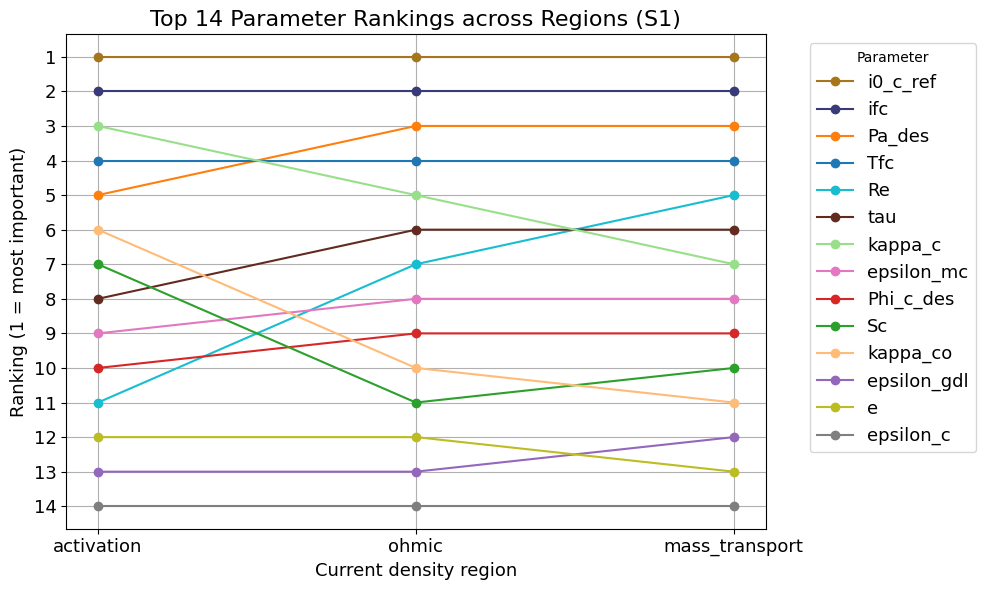

In [6]:
plot_top_k_rankings_across_regions(
    rank_sources={
        "activation": FE_act_sobol_[max_N_sobol_convergence]["sobol_df"],
        "ohmic": FE_ohm_sobol_[max_N_sobol_convergence]["sobol_df"],
        "mass_transport": FE_mass_sobol_[max_N_sobol_convergence]["sobol_df"]
    },
    source_type="S1",
    top_k=14
)

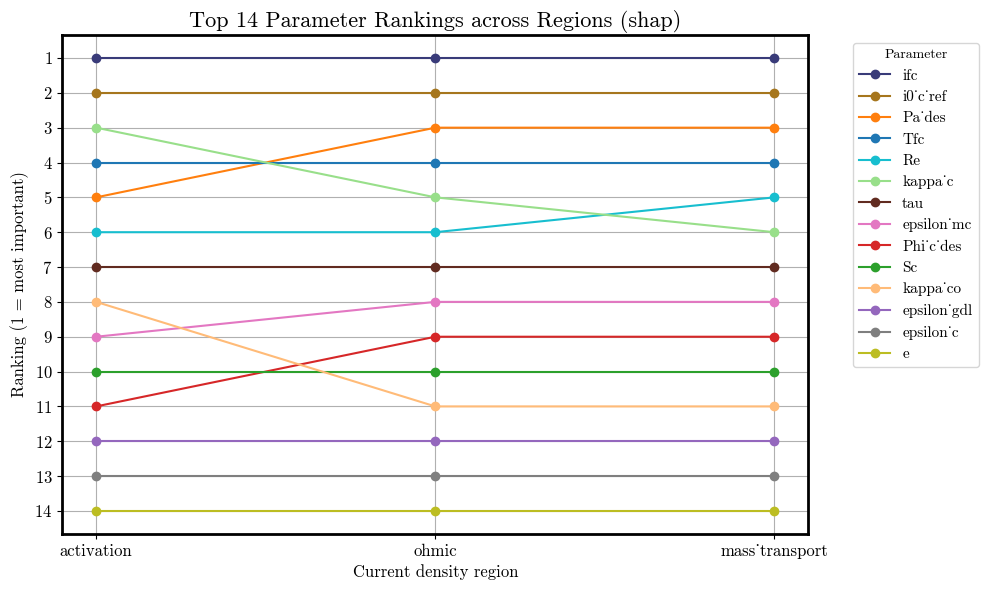

In [82]:
plot_top_k_rankings_across_regions(
    rank_sources={
        "activation": FE_act_shap_results,
        "ohmic": FE_ohm_shap_results,
        "mass_transport": FE_mass_shap_results
    },
    source_type="shap",
    top_k=14
)

3. **Selection of Most Relevant Features**
We identify the set of features that together explain at least 90% of the variance in each region for Sobol, and the top five features (excluding `ifc`) for SHAP. These features are then combined to produce a final list of the most relevant ones across all regions.

In [7]:
selected_features_per_region_sobol, union_set_sobol =select_top_features(
    rank_sources={
        "activation": FE_act_sobol_[max_N_sobol_convergence]["sobol_df"],
        "ohmic": FE_ohm_sobol_[max_N_sobol_convergence]["sobol_df"],
        "mass_transport": FE_mass_sobol_[max_N_sobol_convergence]["sobol_df"]
    },
    source_type="S1",
    method="threshold",
    threshold=0.9,top_k=None
)


Region: activation
Selected 5 features using method='threshold' (threshold=0.9)
Total importance explained: 0.928
Selected features: ['i0_c_ref', 'ifc', 'kappa_c', 'Tfc', 'Pa_des']

Region: ohmic
Selected 6 features using method='threshold' (threshold=0.9)
Total importance explained: 0.908
Selected features: ['i0_c_ref', 'ifc', 'Pa_des', 'Tfc', 'kappa_c', 'tau']

Region: mass_transport
Selected 8 features using method='threshold' (threshold=0.9)
Total importance explained: 0.904
Selected features: ['i0_c_ref', 'ifc', 'Pa_des', 'Tfc', 'Re', 'tau', 'kappa_c', 'epsilon_mc']

Union of all selected features across regions: ['Pa_des', 'Re', 'Tfc', 'epsilon_mc', 'i0_c_ref', 'ifc', 'kappa_c', 'tau']
Total unique features selected: 8


In [8]:
build_feature_ranking_table(selected_features_per_region_sobol)

,activation,ohmic,mass_transport
i0_c_ref,1,1,1
ifc,2,2,2
kappa_c,3,5,7
Tfc,4,4,4
Pa_des,5,3,3
Re,<NA>,<NA>,5
epsilon_mc,<NA>,<NA>,8
tau,<NA>,6,6


In [9]:
selected_features_per_region_shap, union_set_shap = select_top_features(
    rank_sources={
        "activation": FE_act_shap_results,
        "ohmic": FE_ohm_shap_results,
        "mass_transport": FE_mass_shap_results
    },
    source_type="shap",
    method="topk",
    top_k=5
)


Region: activation
Selected 5 features using method='topk' (top_k=5)
Total importance explained: 0.878
Selected features: ['ifc', 'i0_c_ref', 'kappa_c', 'Tfc', 'Pa_des']

Region: ohmic
Selected 5 features using method='topk' (top_k=5)
Total importance explained: 0.762
Selected features: ['ifc', 'i0_c_ref', 'Pa_des', 'Tfc', 'kappa_c']

Region: mass_transport
Selected 5 features using method='topk' (top_k=5)
Total importance explained: 0.756
Selected features: ['ifc', 'i0_c_ref', 'Pa_des', 'Tfc', 'Re']

Union of all selected features across regions: ['Pa_des', 'Re', 'Tfc', 'i0_c_ref', 'ifc', 'kappa_c']
Total unique features selected: 6


In [10]:
build_feature_ranking_table(selected_features_per_region_shap)

,activation,ohmic,mass_transport
ifc,1,1,1
i0_c_ref,2,2,2
kappa_c,3,5,<NA>
Tfc,4,4,4
Pa_des,5,3,3
Re,<NA>,<NA>,5
